In [ ]:
import numpy as np
distance  = np.zeros((51,51))
coordinate = open(r'/content/drive/My Drive/Colab Notebooks/cities_coordinate.txt')  ##讀取位置信息
cities_coordinate = []
for line in coordinate:
  city_nuber, city_x, city_y =  line.split(" ")
  cities_coordinate.append([int(city_x), int(city_y)])
for i in range(len(cities_coordinate)):
  for j in range(len(cities_coordinate)):
    distance[i,j] = ((cities_coordinate[i][0]-cities_coordinate[j][0])**2+(cities_coordinate[i][1]-cities_coordinate[j][1])**2)**0.5 

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

def getKey(dct,value):
     return [key for key in dct if (dct[key] == value)][0]

def get_fitness(vector):  
  total_distance = 0 
  for i in range(len(vector)-1):
    total_distance += distance[vector[i], vector[i+1]]
  return total_distance

def mutate(vector, mutation_rate):  ##每一位數都有mutation_rate的機率變異
  for i in range(len(vector)):
    r = random.uniform(0,1)
    if r < mutation_rate:
      mutate_to = random.randint(0, len(vector)-1)
      vector[i], vector[vector.index(mutate_to)] = mutate_to, vector[i]
  return vector

def crossover(parent_vector1, parent_vector2, mutation_rate, method = "Partially"):  ##結合兩個父母的染色體，拆的地方是隨機的
  if method == "Partially":
    temp = {}
    parent_vector1, parent_vector2 = parent_vector1[:(len(parent_vector1)-1)], parent_vector2[:(len(parent_vector2)-1)]
    start_index = random.randint(1, len(parent_vector1)-2)
    end_index = random.randint(start_index+1, len(parent_vector1)-1)
    for i in range(end_index-start_index+1):
      if parent_vector1[i+start_index] in temp.values():
        temp[getKey(temp, parent_vector1[i+start_index])] = parent_vector2[i+start_index]
      else:
        temp[parent_vector1[i+start_index]] = parent_vector2[i+start_index]
    delete = []

    for repeat in range(len(temp)):
      for one in temp.values():
        if one in temp:
          temp[getKey(temp, one)] = temp[one]
          delete.append(one)
    for one in delete:
      try:
        del temp[one]
      except:
        continue

    for j in range(start_index):
      if parent_vector1[j] in temp.values():
        parent_vector1[j] = getKey(temp, parent_vector1[j])
      if parent_vector2[j] in temp:
        parent_vector2[j] = temp[parent_vector2[j]]

    for k in range(len(parent_vector1)-1-end_index):
      if parent_vector1[k+end_index+1] in temp.values():
        parent_vector1[k+end_index+1] = getKey(temp, parent_vector1[k+end_index+1])
      if parent_vector2[k+end_index+1] in temp:
        parent_vector2[k+end_index+1] = temp[parent_vector2[k+end_index+1]]

    parent_vector1[start_index:(end_index+1)], parent_vector2[start_index:(end_index+1)] = parent_vector2[start_index:(end_index+1)], parent_vector1[start_index:(end_index+1)]
    parent_vector1.append(parent_vector1[0])
    parent_vector2.append(parent_vector2[0])
    parent_vector1, parent_vector2 = mutate(parent_vector1, mutation_rate), mutate(parent_vector2, mutation_rate)
    return [parent_vector1, parent_vector2]

  if method == "circle":
    parent_vector1, parent_vector2 = parent_vector1[:(len(parent_vector1)-1)], parent_vector2[:(len(parent_vector2)-1)]
    start_index = random.randint(0, len(parent_vector1)-1)
    point_record = [start_index]
    point = parent_vector1.index(parent_vector2[start_index])
    while point != start_index:
      point_record.append(point)
      point = parent_vector1.index(parent_vector2[point])
    nonselection = [x for x in range(len(parent_vector1)) if x not in point_record]
    for i in nonselection:
      parent_vector1[i], parent_vector2[i] = parent_vector2[i], parent_vector1[i]
    parent_vector1, parent_vector2 = mutate(parent_vector1, mutation_rate), mutate(parent_vector2, mutation_rate)
    parent_vector1.append(parent_vector1[0])
    parent_vector2.append(parent_vector2[0])
    return [parent_vector1, parent_vector2]
    
  if method == "order":
    parent_vector1, parent_vector2 = parent_vector1[:(len(parent_vector1)-1)], parent_vector2[:(len(parent_vector2)-1)]
    start_index = random.randint(1, len(parent_vector1)-2)
    end_index = random.randint(start_index+1, len(parent_vector1)-1)
    unchange1 = parent_vector1[start_index:(end_index+1)]
    unchange2 = parent_vector2[start_index:(end_index+1)]
    change1 = []
    change2 = []
    for one in parent_vector2:
      if one not in unchange1:
        change1.append(one)

    for one in parent_vector1:
      if one not in unchange2:
        change2.append(one)
      
    parent_vector1[:start_index], parent_vector2[:start_index] = change1[(-start_index):], change2[(-start_index):]
    parent_vector1[(end_index+1):], parent_vector2[(end_index+1):] = change1[:(-start_index)], change2[:(-start_index)]
    parent_vector1.append(parent_vector1[0])
    parent_vector2.append(parent_vector2[0])
    parent_vector1, parent_vector2 = mutate(parent_vector1, mutation_rate), mutate(parent_vector2, mutation_rate)
    return [parent_vector1, parent_vector2]

def select(population, crossover_rate, method = "Tournament"):  ##根據Roulette wheel selection或者Tournament selection的方法選擇可以繁衍的染色體
  selection = []
  selection_num = 2 * int(len(population) * crossover_rate/2)
  if method == "Roulette":
    fitness = []
    for chromosome in population:
      fitness.append(1/get_fitness(chromosome))
    k = 0
    while len(selection) < selection_num:
      k += 1
      i = k % len(population)
      r = random.uniform(0,1)
      if r < fitness[i]/sum(fitness):
        selection.append(population[i])

  if method == "Tournament":
    while len(selection) < selection_num:
      n_select = random.choices(population, k =5)
      n_select_fitness = []
      for chromosome in n_select:
        n_select_fitness.append(get_fitness(chromosome))
      selection.append(n_select[np.argmin(n_select_fitness)])  
  return selection

In [ ]:
def initial_population(population_per_island, island_number):  ##隨機生成初始population
  population = []
  island_population = []
  for i in range(population_per_island * island_number):
    chromosome = random.sample([x for x in range(51)],  k=51)
    chromosome.append(chromosome[0])
    population.append(chromosome)
  for j in range(island_number):
    island_population.append(population[(j*population_per_island):((j+1)*population_per_island)])
  return island_population

In [ ]:
def GA_for_single_island(population, mutation_rate, crossover_rate, max_generation, selection_method, crossover_method):
  for generation in range(max_generation):
    selection = select(population, crossover_rate, method = selection_method)  ##根據crossover_rate選擇一定數量的染色體用來繁衍（可能重複）
    nonselection = [x for x in population if x not in selection]  ##將沒被選上的拿出來
    selection = random.sample(selection,  k=len(selection))  ##打亂順序繁衍
    offspring = []
    for j in range(int(len(selection)/2)):
      offspring = offspring + crossover(selection[2*j], selection[2*j+1], mutation_rate, method = crossover_method)  ##將選中的染色體兩兩配對繁衍
    population = nonselection[0:(100-len(offspring))] + offspring  ##由於選擇的時候可能重複，因此為了不讓總population超過100，刪去一部分沒被選上的染色體
    population_fitness = []

    for one in population:
      population_fitness.append(get_fitness(one))
  return population, population_fitness

In [ ]:
max_run = 30
population_size_per_island = 100  ##每個島的人口數
island_num = 4  ## 小島數量
generation_per_exchange = 10  ##多少個generation交換一次信息
mutation_rate = 0.01  
crossover_rate = 0.8
max_generation = 1000
selection_method = "Tournament"
crossover_method = "Partially"
record = np.zeros((max_run, max_generation//generation_per_exchange), dtype='int') ##紀錄信息

for run in range(max_run):
  population = initial_population(population_size_per_island, island_num)  ##初始化人口
  for l in range(max_generation//generation_per_exchange):
    best_fitness_per_island = []  ##紀錄每個小島最好的染色體
    best_chromosome_per_island = [] 
    for k in range(island_num):
      population[k], population_fitness = GA_for_single_island(population[k], mutation_rate, crossover_rate, generation_per_exchange, selection_method, crossover_method) ##單一小島跑GA
      best_fitness_per_island.append(min(population_fitness))  ##紀錄
      best_chromosome_per_island.append(population[k][np.argmin(np.array(population_fitness))]) ##提取每個小島最好的染色體
      del population[k][np.argmin(np.array(population_fitness))]
      if k !=0:
        population[k].append(best_chromosome_per_island[k-1])  ##染色體交換
    population[0].append(best_chromosome_per_island[k])
    print(run, l, min(best_fitness_per_island))
    record[run, l] = min(best_fitness_per_island)
    

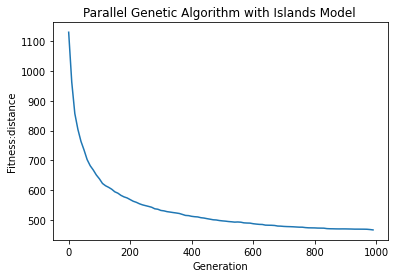

In [ ]:
average_record = np.mean(record, axis = 0) ##取30次平均
title = 'Parallel Genetic Algorithm with Islands Model '
plt.title(title)
plt.xlabel('Generation')
plt.ylabel('Fitness:distance')
plt.plot([10*x for x in range(max_generation//generation_per_exchange)], average_record, '-')